## 패키지 설치

In [1]:
!pip install sdv
!pip install datetime
!pip install tqdm
#!pip install matplotlib==3.1.3
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 10.9 MB/s 
     |████████████████████████████████| 139 kB 54.5 MB/s 
     |████████████████████████████████| 47 kB 4.9 MB/s 
     |████████████████████████████████| 1.6 MB 47.7 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 61 kB 417 kB/s 
     |████████████████████████████████| 9.4 MB 44.9 MB/s 
     |████████████████████████████████| 965 kB 62.0 MB/s 
     |████████████████████████████████| 295 kB 67.6 MB/s 
     |████████████████████████████████| 662 kB 60.6 MB/s 
     |████████████████████████████████| 280 kB 70.2 MB/s 
     |████████████████████████████████| 15.3 MB 69.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: psutil
    Found existing installation: 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 261 kB 59.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (27.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is i

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
import pickle
warnings.filterwarnings(action='ignore')

from sdv.timeseries import PAR
from sdmetrics.single_column import BoundaryAdherence
from sdmetrics.single_column import RangeCoverage
from sdmetrics.column_pairs import CorrelationSimilarity
from sdmetrics.single_column import KSComplement
from sdmetrics.single_column import MissingValueSimilarity
from sdmetrics.single_column import StatisticSimilarity

# 증식할 상추 data 불러오기
- 생성모델을 사용하는 목적은 그룹별 최적 환경 파일을 만들기 위함이다.
- 최적 환경 파일 1개를 만들기 위해서는 그룹별 케이스를 모두 증식시킨 뒤 평균 내려고 함.
- 케이스별 N번 증식 -> 검증 -> 원본과 비슷한 분포만 선별 -> 최적 환경 (검증 목적은 원본데이터랑 분포가 비슷한 데이터셋을 만들어 냈는지 확인하는 것이므로)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#기본 경로 지정
%cd /content/drive/MyDrive/2022_상추의 생육 환경 생성 AI 경진대회/생성모델

/content/drive/.shortcut-targets-by-id/1-EzLt_gX0CI4hJP3C7mM2Fn5AZVbAmPI/2022_상추의 생육 환경 생성 AI 경진대회/생성모델


## 데이터프레임 준비
모든 train_input.csv를 행 방향으로 합쳐 하나의 데이터프레임을 만듭니다.

In [4]:
# 모든 파일 이름을 리스트에 합치기
all_input_list = sorted(glob.glob('train_input/*.csv'))

# 데이터프레임 생성
data = pd.DataFrame()
for i in all_input_list:
    add = pd.read_csv(i)
    data = pd.concat([data, add], axis=0)
    data = data.reset_index(drop=True)

# case 번호 추가
case_num = [[i]*672 for i in range(1,29)]
data.insert(0, 'case', np.array(case_num).flatten().tolist())

# 모델 학습 시 필요한 Y-M-D H:00:00 형식의 datetime 추가
start_date = pd.to_datetime('2022-10-01')
end_date = pd.to_datetime('2022-10-29')
dates = pd.date_range(start_date,end_date,freq='H') # 시간단위로 생성
dates = dates[:-1] # 마지막 10/29 00:00:00은 삭제

time_list=[]
for i in range(28):
  for j in range(672):
    time_list.append(dates[j])
data.insert(1, 'datetime', time_list)

# 기존 DAT, obs_time 삭제
data = data.drop(['DAT', 'obs_time'], axis=1)
data_raw = data
data.head()

,case,datetime,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,1,2022-10-01 00:00:00,25.300000,81.835000,536.016667,1.407439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2022-10-01 01:00:00,25.680357,81.264286,528.696429,1.409003,126.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2022-10-01 02:00:00,25.273333,81.471666,532.833333,1.406913,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2022-10-01 03:00:00,25.355000,81.398334,545.566667,1.406689,126.0,252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2022-10-01 04:00:00,25.391667,81.483333,558.583333,1.411070,0.0,252.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 전처리
누적 변수는 데이터 증식에 불필요하므로 모두 제거하고 환경변수별 제한범위를 벗어나는 값을 전처리합니다. (데이터 증식 후 다시 누적 변수 생성)

In [5]:
def preprocess(df):
    df=df.drop(['일간누적분무량', '일간누적백색광량', '일간누적적색광량', '일간누적청색광량', '시간당총광량', '일간누적총광량'], axis=1)

# 내부온도 전처리 함수
    df['내부온도관측치']=np.where(df['내부온도관측치']<4,4,df['내부온도관측치'])
    df['내부온도관측치']=np.where(df['내부온도관측치']>40,40,df['내부온도관측치'])

# 내부습도 전처리 함수
    df['내부습도관측치']=np.where(df['내부습도관측치']<0,0,df['내부습도관측치'])
    df['내부습도관측치']=np.where(df['내부습도관측치']>100,100,df['내부습도관측치'])

# co2관측치 전처리 함수
    df['co2관측치']=np.where(df['co2관측치']<0,0,df['co2관측치'])
    df['co2관측치']=np.where(df['co2관측치']>1200,1200,df['co2관측치'])

# ec관측치 전처리 함수
    df['ec관측치']=np.where(df['ec관측치']<0,0,df['ec관측치'])
    df['ec관측치']=np.where(df['ec관측치']>8,8,df['ec관측치'])

# 분무량 전처리 함수
    df['시간당분무량']=np.where(df['시간당분무량']<0,0,df['시간당분무량'])
    df['시간당분무량']=np.where(df['시간당분무량']>3000,3000,df['시간당분무량'])
    #df['일간누적분무량']=np.where(df['일간누적분무량']>72000, 72000, df['일간누적분무량'])

# 광량 전처리 함수
    df['시간당백색광량']=np.where(df['시간당백색광량']<0, 0, df['시간당백색광량'])
    df['시간당적색광량']=np.where(df['시간당적색광량']<0, 0, df['시간당적색광량'])
    df['시간당청색광량']=np.where(df['시간당청색광량']<0, 0, df['시간당청색광량'])
    #df['시간당총광량']=np.where(df['시간당총광량']<0, 0, df['시간당총광량'])
    df['시간당백색광량']=np.where(df['시간당백색광량']>120000, 120000, df['시간당백색광량'])
    df['시간당적색광량']=np.where(df['시간당적색광량']>120000, 120000, df['시간당적색광량'])      
    df['시간당청색광량']=np.where(df['시간당청색광량']>120000, 120000, df['시간당청색광량'])    
    #df['시간당총광량']=np.where(df['시간당총광량']>120000, 120000, df['시간당총광량'])    
    #df['일간누적백색광량']=np.where(df['일간누적백색광량']<0, 0, df['일간누적백색광량']) 
    #df['일간누적적색광량']=np.where(df['일간누적적색광량']<0, 0, df['일간누적적색광량']) 
    #df['일간누적청색광량']=np.where(df['일간누적청색광량']<0, 0, df['일간누적청색광량']) 
    #df['일간누적총광량']=np.where(df['일간누적총광량']<0, 0, df['일간누적총광량']) 
    #df['일간누적백색광량']=np.where(df['일간누적백색광량']>2880000, 2880000, df['일간누적백색광량']) 
    #df['일간누적적색광량']=np.where(df['일간누적적색광량']>2880000, 2880000, df['일간누적적색광량']) 
    #df['일간누적청색광량']=np.where(df['일간누적청색광량']>2880000, 2880000, df['일간누적청색광량']) 
    #df['일간누적총광량']=np.where(df['일간누적총광량']>2880000, 2880000, df['일간누적총광량'])    
    return df

data = preprocess(data)
data.describe()

,case,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량
count,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000,18816.000000
mean,14.500000,26.027555,63.935090,497.946074,1.507566,523.683543,6322.916844,1572.330259,1242.892953
std,8.077962,3.946296,11.657905,113.892200,1.042010,544.191574,8119.967921,2936.302749,2470.223421
min,1.000000,4.000000,0.000000,60.400000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.750000,23.971250,57.494583,420.245833,0.929581,0.000000,0.000000,0.000000,0.000000
50%,14.500000,26.291667,62.118333,473.983333,1.308517,252.000000,0.000000,0.000000,0.000000
75%,21.250000,28.106667,73.157166,551.105952,2.291322,769.000000,18236.625400,1494.698100,1306.461000
max,28.000000,40.000000,93.350002,1200.000000,5.462324,3000.000000,18564.600000,9928.800000,9399.000000


## 모델 학습 및 저장
시계열 형태의 합성 데이터를 생성할 수 있는 SDV의 PAR 모델을 사용합니다. PAR 모델은 확률론적 자기회귀 모델(Probabilistic AutoRegressive model)로, 다변량 시계열 데이터를 학습하여 그와 같은 형식의 데이터를 생성해줍니다.

In [6]:
entity_columns = ['case']
sequence_index = 'datetime'
'''
entity_columns: case 1개와 연관된 행끼리 time series sequence를 이루며 같은 case의 행은 서로 연관되지만 다른 case의 행은 서로 독립적임을 알려줍니다.
sequence index: 각 sequence 내에서 행의 순서를 알려주기 위해 datetime으로 지정합니다.
'''
model = PAR(entity_columns=entity_columns,
            sequence_index=sequence_index)

model.fit(data)

In [ ]:
model.save('data_fit.pkl')

## 모델 불러오기 및 데이터 증식

최적 환경 생성에 적합한 case를 선별하여 데이터를 증식합니다. 선별 과정은 아래와 같습니다.
1. DAT1 잎 중량을 기준으로 전체 28개 case를 상위 25%, 중위 50%, 하위 25% 총 3개 그룹으로 나눕니다.
2. 그룹별로 DAT28까지 잘 자란 case를 선별합니다. 이때 잘 자란 case는 (1) DAT28 잎 중량이 무겁거나 (2) 성장률이 높은 case입니다.
- 성장률 $= growth\_rate = \frac{(DAT28~중량)-(DAT1~중량)}{(DAT1~중량)}$

- `good1`: `DAT1` 잎 중량 상위 25% 중 `DAT28`까지 잘 자란 case 5, 11, 13, 14, 16
- `good2`: `DAT1` 잎 중량 중위 50% 중 `DAT28`까지 잘 자란 case 12, 15
- `good3`: `DAT1` 잎 중량 하위 25% 중 `DAT28`까지 잘 자란 case 17, 19, 24

대회에서 제공한 변수만 넣고 증식 -> 검증 -> 분포가 가장 비슷한 것 n개만 선별 -> 최적 환경 만들기 -> 그 이후에 파생변수 생성해 환경변수 df 완성 -> xgb -> weight 예측

In [ ]:
# 그룹마다 10번씩 샘플링
loaded = PAR.load('data_fit.pkl')

- g1 : 처음부터 무거웠을 경우 나중에도 무겁게 성장한 case
- g2 : 첫날 중위 50% 중 잘 자란 case
- g3 : 처음에는 가벼웠으나 높은 성장률로 성장한 case

In [ ]:
g1 = [5, 11, 13, 14, 16] 
g2 = [12, 15]
g3 = [17, 19, 24]

g1_context = pd.DataFrame({'case': g1})
g2_context = pd.DataFrame({'case': g2})
g3_context = pd.DataFrame({'case': g3})

In [ ]:
# 데이터 증식 함수
def sample_(context):
  new_data_list = []
  for i in range(30):
    new_data_list.append(loaded.sample(context=context))
  return new_data_list


# 증식된 데이터 검증 함수
def evaluate_(input):
  '''
  input: sample_(good1_context) : sampling된 데이터프레임이 원소로 들어가있는 list
  input[i]로 i번째 sampling된 데이터프레임을 꺼낼 수 있다
  '''
  eval_list = []
  for i in range(len(input)):
      case_list = input[i]['case'].unique()
      eval_each_sampling = []

      for j in range(len(case_list)):
          # case마다 검증 지표가 담긴 데이터프레임 1개 생성
          # Subset
          new_subset = input[i][input[i]['case'] == case_list[j]]
          real_subset = data[data['case'] == case_list[j]]

          # 검증 지표
          column_list = input[i].columns[2:]
          eval_each_case = pd.DataFrame(index=['BA', 'RC', 'KSC', 'MVS', 'SS_mean', 'SS_median', 'SS_std'])
          for k in range(len(column_list)):
              col = column_list[k]
              BA = BoundaryAdherence.compute(real_data=real_subset[col], synthetic_data=new_subset[col])
              RC = RangeCoverage.compute(real_data=real_subset[col], synthetic_data=new_subset[col])
              KSC = KSComplement.compute(real_data=real_subset[col], synthetic_data=new_subset[col])
              MVS = MissingValueSimilarity.compute(real_data=real_subset[col], synthetic_data=new_subset[col])
              SS_mean = StatisticSimilarity.compute(real_data=real_subset[col], synthetic_data=new_subset[col], statistic='mean')
              SS_median = StatisticSimilarity.compute(real_data=real_subset[col], synthetic_data=new_subset[col], statistic='median')
              SS_std = StatisticSimilarity.compute(real_data=real_subset[col], synthetic_data=new_subset[col], statistic='std')
              '''
              [평가지표 소개]
              BoundaryAdherence: 합성 데이터가 실제 데이터의 범위(min, max) 안에 있는지 평가
              RangeCoverage: 합성 데이터가 실제 데이터의 범위의 몇 퍼센트를 커버하는지 평가
              KSComplement: 한 컬럼의 분포가 얼마나 유사한지 평가 (두 누적분포함수 CDF 차이의 최댓값)
              MissingValueSimilarity: 결측치 비율이 유사한지 평가
              StatisticSimilarity: 요약 통계량이 얼마나 유사한지 평가
              '''
              eval_each_case[col] = [BA, RC, KSC, MVS, SS_mean, SS_median, SS_std]

          eval_each_sampling.append(eval_each_case)

      eval_list.append(eval_each_sampling)
  return eval_list


# 검증 점수 총점 구하는 함수
def evaluate_final_(df, group):
  '''
  df = evaluate_(sample_(good1_context))
  group = g1, g2, g3
  '''
  final_score = pd.DataFrame()

  for i in range(len(df)):
    for j in range(len(df[i])): # i:0-9, j:0-4
      df[i][j]['RowSum'] = df[i][j].sum(axis=1) # 각 행의 합계
      final_score.loc[i,j] = df[i][j].iloc[-1,-1] # 샘플링된 순서 & case 번호와 매칭
  final_score.columns = group
  return final_score  

In [ ]:
g1_new_data = sample_(g1_context)
g2_new_data = sample_(g2_context)
g3_new_data = sample_(g3_context)

## 증식된 합성 데이터 pickle 로 저장 및 불러오기

In [ ]:
with open("g1_new_data.pickle","wb") as f:
    pickle.dump(g1_new_data, f) 
with open("g2_new_data.pickle","wb") as f:
    pickle.dump(g2_new_data, f)
with open("g3_new_data.pickle","wb") as f:
    pickle.dump(g3_new_data, f)       

In [ ]:
with open('g1_new_data.pickle','rb') as f:
   g1_new_data = pickle.load(f)

with open('g2_new_data.pickle','rb') as f:
   g2_new_data = pickle.load(f)

with open('g3_new_data.pickle','rb') as f:
   g3_new_data = pickle.load(f)         

good1 case에 대해
1. loaded.sample로 good1 케이스 5개만 증식해서 df 만들기 -> 10번
2. 데이터프레임 10개에는 5, 11, 13, 14, 16번 케이스가 각각 10번씩 증식되어있다.
3. 증식된 데이터가 원본 case 5와 비슷한지 검증 -> 비슷한 것만 선택
4. good1 모든 케이스끼리 평균 내서 df 1개 만들자.

## 평가

In [ ]:
g1_eval = evaluate_(g1_new_data)
g2_eval = evaluate_(g2_new_data)
g3_eval = evaluate_(g3_new_data)

## 1. good1 검증결과
- case : 5,11,13,14,16

In [ ]:
g1_eval[0][0] # 0번째 sampling된 데이터프레임의 0번째 케이스(case5)의 검증 결과

,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량
BA,0.601190,0.293155,0.956845,0.961310,0.846726,0.782738,0.000000,0.000000
RC,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN
KSC,0.687500,0.305060,0.724702,0.400298,0.668155,0.580357,0.285714,0.333333
MVS,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
SS_mean,0.783930,0.105624,0.893523,0.805502,0.915453,0.869056,NaN,NaN
SS_median,0.856364,0.063028,0.895450,0.721487,0.800019,0.759685,NaN,NaN
SS_std,0.776701,0.562853,0.899332,0.960027,0.902163,0.897844,NaN,NaN


요약 통계량 비교

In [ ]:
# g1_eval은 2차원(이중) 리스트이다.
print('샘플링 횟수:', len(g1_eval)) # 30번 샘플링했으므로 list 원소는 30개
print('그룹별 case 개수:', len(g1_eval[0])) # good1 case가 5개이므로 list의 원소는 5개

샘플링 횟수: 30
그룹별 case 개수: 5


In [ ]:
g1_final = evaluate_final_(g1_eval, g1)
g2_final = evaluate_final_(g2_eval, g2)
g3_final = evaluate_final_(g3_eval, g3)

g1_final
# index = sampling 순서 (몇 번째로 sampling된 데이터프레임인가)
# 컬럼 = case 번호

,5,11,13,14,16
0,4.998920,6.364655,6.090578,5.857536,6.754030
1,5.000165,6.360670,6.092676,5.873173,6.772784
2,4.978191,6.395885,6.097310,5.836172,6.759711
3,5.055939,6.381251,6.117724,5.856154,6.790336
4,5.045449,6.390195,6.052430,5.872016,6.784185
5,5.019629,6.397188,6.107668,5.874348,6.747579
6,5.071298,6.416175,6.096367,5.879854,6.759572
7,5.039780,6.387714,6.076646,5.863127,6.751182
8,5.003638,6.379362,6.115874,5.890592,6.744189
9,5.009940,6.407283,6.109064,5.863587,6.776196


In [ ]:
# g1 인덱스
case5_sampling_index = g1_final.sort_values(by=g1[0], ascending=False).head(5).index.values
case11_sampling_index = g1_final.sort_values(by=g1[1], ascending=False).head(5).index.values
case13_sampling_index = g1_final.sort_values(by=g1[2], ascending=False).head(5).index.values
case14_sampling_index = g1_final.sort_values(by=g1[3], ascending=False).head(5).index.values
case16_sampling_index = g1_final.sort_values(by=g1[4], ascending=False).head(5).index.values

# g2 인덱스
case12_sampling_index = g2_final.sort_values(by=g2[0], ascending=False).head(5).index.values
case15_sampling_index = g2_final.sort_values(by=g2[1], ascending=False).head(5).index.values

# g3 인덱스
case17_sampling_index = g3_final.sort_values(by=g3[0], ascending=False).head(5).index.values
case19_sampling_index = g3_final.sort_values(by=g3[1], ascending=False).head(5).index.values
case24_sampling_index = g3_final.sort_values(by=g3[2], ascending=False).head(5).index.values

g1_final_index = [case5_sampling_index, case11_sampling_index, case13_sampling_index, case14_sampling_index, case16_sampling_index]
g2_final_index = [case12_sampling_index, case15_sampling_index]
g3_final_index = [case17_sampling_index, case19_sampling_index, case24_sampling_index]

print(f'기존 good1 case는 {g1}이며')
print(f'case {g1[0]}의 증식 데이터 중 {case5_sampling_index}번째 샘플링 데이터가 선정되었습니다')
print(f'case {g1[1]}의 증식 데이터 중 {case11_sampling_index}번째 샘플링 데이터가 선정되었습니다')
print(f'case {g1[2]}의 증식 데이터 중 {case13_sampling_index}번째 샘플링 데이터가 선정되었습니다')
print(f'case {g1[3]}의 증식 데이터 중 {case14_sampling_index}번째 샘플링 데이터가 선정되었습니다')
print(f'case {g1[4]}의 증식 데이터 중 {case16_sampling_index}번째 샘플링 데이터가 선정되었습니다')
print('---')
print(f'기존 good2 case는 {g2}이며')
print(f'case {g2[0]}의 증식 데이터 중 {case12_sampling_index}번째 샘플링 데이터가 선정되었습니다')
print(f'case {g2[1]}의 증식 데이터 중 {case15_sampling_index}번째 샘플링 데이터가 선정되었습니다')
print('---')
print(f'기존 good3 case는 {g3}이며')
print(f'case {g3[0]}의 증식 데이터 중 {case17_sampling_index}번째 샘플링 데이터가 선정되었습니다')
print(f'case {g3[1]}의 증식 데이터 중 {case19_sampling_index}번째 샘플링 데이터가 선정되었습니다')
print(f'case {g3[2]}의 증식 데이터 중 {case24_sampling_index}번째 샘플링 데이터가 선정되었습니다')

기존 good1 case는 [5, 11, 13, 14, 16]이며
case 5의 증식 데이터 중 [21 29 12 15  6]번째 샘플링 데이터가 선정되었습니다
case 11의 증식 데이터 중 [25 21 26 16  6]번째 샘플링 데이터가 선정되었습니다
case 13의 증식 데이터 중 [17 14 29  3  8]번째 샘플링 데이터가 선정되었습니다
case 14의 증식 데이터 중 [25 17  8 27  6]번째 샘플링 데이터가 선정되었습니다
case 16의 증식 데이터 중 [13  3 15  4 19]번째 샘플링 데이터가 선정되었습니다
---
기존 good2 case는 [12, 15]이며
case 12의 증식 데이터 중 [20  5 19 26 12]번째 샘플링 데이터가 선정되었습니다
case 15의 증식 데이터 중 [ 0 28  3 21 12]번째 샘플링 데이터가 선정되었습니다
---
기존 good3 case는 [17, 19, 24]이며
case 17의 증식 데이터 중 [11  2  0  5 24]번째 샘플링 데이터가 선정되었습니다
case 19의 증식 데이터 중 [ 0  3 28 17 14]번째 샘플링 데이터가 선정되었습니다
case 24의 증식 데이터 중 [15 29  6 16  7]번째 샘플링 데이터가 선정되었습니다


In [ ]:
g1_new_data[0]

,case,datetime,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량
0,5,2022-10-01 00:00:00,29.660969,60.872955,568.397810,1.835939,228.878958,6710.006113,4377.847496,-934.905533
1,5,2022-10-01 01:00:00,26.230356,63.935090,498.005885,1.533503,407.023067,-770.466253,-1507.190254,2308.685689
2,5,2022-10-01 02:00:00,30.656989,70.282458,575.060896,1.801730,-579.790678,-835.123370,-650.746340,-276.535761
3,5,2022-10-01 03:00:00,34.047984,54.006700,583.323867,1.175515,-103.314528,1142.435027,-819.234151,1242.892953
4,5,2022-10-01 04:00:00,27.611245,65.510707,497.946074,0.985702,398.936738,-2820.666869,-895.776975,-352.897504
...,...,...,...,...,...,...,...,...,...,...
3355,16,2022-10-28 19:00:00,26.354591,63.870309,463.355282,-0.509185,1179.614520,20389.555619,-784.421688,479.523908
3356,16,2022-10-28 20:00:00,25.447294,72.241228,540.130245,1.140853,937.276892,1206.095639,320.785705,-598.213243
3357,16,2022-10-28 21:00:00,26.520572,74.448221,446.087300,1.917391,523.683543,11840.634338,-5.072414,1140.376320
3358,16,2022-10-28 22:00:00,22.072038,56.270127,402.350470,0.972136,1007.107504,4216.355895,-90.165481,-1207.711711


In [ ]:
g1_final_index

[array([21, 29, 12, 15,  6]),
 array([25, 21, 26, 16,  6]),
 array([17, 14, 29,  3,  8]),
 array([25, 17,  8, 27,  6]),
 array([13,  3, 15,  4, 19])]

In [ ]:
# 최적 환경 파일 만드는 함수
def make_best_environ_(input, group, group_index):
  '''
  input = g1_new_data, g2_new_data, g2_new_data 
  group = g1, g2, g3
  group_index = g1_final_index, g2_final_index, g3_final_index
  '''
  df = pd.DataFrame()
  for i in range(len(group)):
    for j in range(5):
      subset = input[group_index[i][j]]
              # group_index[i][j] = (i=0이라면) case5_sampling_index[j] = (j=0이라면) 5 => input[group_index[i][j]]=g1_new_data[5] 즉 5번째 샘플링 데이터
              # i=1이면 case11_sampling_index[j] ...
      subset = subset[subset['case']==group[i]] # case==case_N만 추출
      df = pd.concat([df, subset], axis=0, ignore_index=True) # 행 방향으로 이어 붙임
  return df.groupby('datetime').mean()

In [ ]:
g1_best_environ = make_best_environ_(g1_new_data, g1, g1_final_index)
g2_best_environ = make_best_environ_(g2_new_data, g2, g2_final_index)
g3_best_environ = make_best_environ_(g3_new_data, g3, g3_final_index)
g1_best_environ

,case,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량
datetime,,,,,,,,,
2022-10-01 00:00:00,11.8,26.140908,65.195161,492.392137,1.705043,566.669212,6447.691107,1452.253620,1167.977326
2022-10-01 01:00:00,11.8,25.227698,66.067480,485.359261,1.511243,531.485870,5764.263366,1196.144803,1238.255702
2022-10-01 02:00:00,11.8,25.128636,67.673696,491.857458,1.330250,679.799326,6771.067119,1407.966565,516.927347
2022-10-01 03:00:00,11.8,25.641992,65.690903,487.391731,1.225536,587.312946,7768.940751,1069.961709,103.978672
2022-10-01 04:00:00,11.8,25.113026,66.726705,477.829730,1.275338,443.064839,5823.179133,226.460291,256.471570
...,...,...,...,...,...,...,...,...,...
2022-10-28 19:00:00,11.8,25.090328,67.202386,457.544238,1.189311,575.864575,4100.812861,518.265474,469.636669
2022-10-28 20:00:00,11.8,25.243200,65.002579,476.204505,1.134104,602.298901,7489.723578,491.756808,616.053277
2022-10-28 21:00:00,11.8,26.358341,65.347609,492.557584,0.980075,478.171775,6154.449380,771.036534,660.113110


# 증식된 데이터를 기반으로 train 셋과 동일한 변수로 데이터프레임 변환

- g1_best_environ
- g2_best_environ
- g3_best_environ


## DAT, obs_time feature 생성

In [ ]:
def make_obs(x):

    x['datetime'] = x.index
    x = x.reset_index(drop=True)
    x['obs_time'] = x['datetime'].dt.hour
    x['DAT'] = x['datetime'].dt.day
    x['DAT'] = x['DAT']-1
    x.drop(['datetime'], axis=1, inplace=True)

    x = x[['DAT', 'obs_time', 'case', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량', '시간당백색광량', '시간당적색광량', '시간당청색광량']]
    
    return x

## 누적 변수들 생성
- obs_time  == 0 일 때마다 누적 합을 새롭게 계산합니다

In [ ]:
def cum(x):
  #df['일간누적분무량']=df.groupby((df['obs_time']==0).cumsum())['시간당분무량'].cumsum()
  x['일간누적분무량'] = x.groupby((x['obs_time']==0).cumsum())['시간당분무량'].cumsum()
  x['일간누적백색광량'] = x.groupby((x['obs_time']==0).cumsum())['시간당백색광량'].cumsum()
  x['일간누적적색광량'] =  x.groupby((x['obs_time']==0).cumsum())['시간당적색광량'].cumsum()
  x['일간누적청색광량'] = x.groupby((x['obs_time']==0).cumsum())['시간당청색광량'].cumsum()
  x['일간누적총광량'] = x['일간누적백색광량']+x['일간누적적색광량']+x['일간누적청색광량']
  x['시간당총광량'] = x['시간당백색광량']+x['시간당적색광량']+x['시간당청색광량']
  return x

In [ ]:
def f(x):
  d = {}
  d['내부온도관측치'] = x['내부온도관측치'].median()
  d['내부습도관측치'] = x['내부습도관측치'].median()
  d['co2관측치'] = x['co2관측치'].median()
  d['ec관측치'] = x['ec관측치'].median()
  d['시간당분무량'] = x['시간당분무량'].median()
  d['일간누적분무량'] = x['일간누적분무량'].max()
  d['시간당백색광량'] = x['시간당백색광량'].median()
  d['일간누적백색광량'] = x['일간누적백색광량'].max()
  d['시간당적색광량'] = x['시간당적색광량'].median()
  d['일간누적적색광량'] = x['일간누적적색광량'].max()
  d['시간당청색광량'] = x['시간당청색광량'].median()
  d['일간누적청색광량'] = x['일간누적청색광량'].max()
  d['시간당총광량'] = x['시간당총광량'].median()
  d['일간누적총광량'] = x['일간누적총광량'].max()
  

  return pd.Series(d, index =['내부온도관측치', '내부습도관측치', 'co2관측치',
       'ec관측치', '시간당분무량', '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량',
       '일간누적적색광량', '시간당청색광량', '일간누적청색광량', '시간당총광량', '일간누적총광량'])

In [ ]:
# 내부온도 전처리 함수
def preproc_temper(df):
    df['내부온도관측치']=np.where(df['내부온도관측치']<4,4,df['내부온도관측치'])
    df['내부온도관측치']=np.where(df['내부온도관측치']>40,40,df['내부온도관측치'])
    return df
# 내부습도 전처리 함수
def preproc_hum(df):
    df['내부습도관측치']=np.where(df['내부습도관측치']<0,0,df['내부습도관측치'])
    df['내부습도관측치']=np.where(df['내부습도관측치']>100,100,df['내부습도관측치'])
    return df
# co2관측치 전처리 함수
def preproc_co2(df):
    df['co2관측치']=np.where(df['co2관측치']<0,0,df['co2관측치'])
    df['co2관측치']=np.where(df['co2관측치']>1200,1200,df['co2관측치'])
    return df
# ec관측치 전처리 함수
def preproc_ec(df):
    df['ec관측치']=np.where(df['ec관측치']<0,0,df['ec관측치'])
    df['ec관측치']=np.where(df['ec관측치']>8,8,df['ec관측치'])
    return df
# 분무량 전처리 함수
def preproc_spray(df):
    df['시간당분무량']=np.where(df['시간당분무량']<0,0,df['시간당분무량'])
    df['시간당분무량']=np.where(df['시간당분무량']>3000,3000,df['시간당분무량'])
    df['일간누적분무량']=np.where(df['일간누적분무량']>72000, 72000, df['일간누적분무량'])
    return df

# 광량 전처리 함수
def preproc_light(df):
    df['시간당백색광량']=np.where(df['시간당백색광량']>120000, 120000, df['시간당백색광량'])
    df['시간당적색광량']=np.where(df['시간당적색광량']>120000, 120000, df['시간당적색광량'])      
    df['시간당청색광량']=np.where(df['시간당청색광량']>120000, 120000, df['시간당청색광량'])    
    df['일간누적백색광량']=np.where(df['일간누적백색광량']>2880000, 2880000, df['일간누적백색광량']) 
    df['일간누적청색광량']=np.where(df['일간누적청색광량']>2880000, 2880000, df['일간누적청색광량']) 
    df['일간누적적색광량']=np.where(df['일간누적적색광량']>2880000, 2880000, df['일간누적적색광량']) 
    df['시간당총광량']=np.where(df['시간당총광량']>120000, 120000, df['시간당총광량'])
    df['일간누적총광량']=np.where(df['일간누적총광량']>2880000, 2880000, df['일간누적총광량'])    
    return df

In [ ]:
def new_col(particular_case): # 변수 전처리 함수
  particular_case = make_obs(particular_case)
  particular_case = cum(particular_case)
  group_df = particular_case.groupby('DAT').apply(f) # 날짜에 대하여 groupby 한 함수 생성
  
  new_group_df = group_df  # 날짜에 대하여 groupby 된 groupbydf 에 대하여 평균값으로 치환해 데이터프레임 생성
  # 파생변수
  new_group_df['습도_온도'] = new_group_df['내부온도관측치'] * new_group_df['내부습도관측치'] # 습도_온도 변수
  new_group_df['습도_온도_CO2'] = new_group_df['습도_온도'] * new_group_df['co2관측치'] # 습도_온도_co2
  new_group_df['비료'] = new_group_df['ec관측치']*new_group_df['일간누적분무량'] # 비료
  med=new_group_df['내부온도관측치'].median()
  temp=np.where(new_group_df['내부온도관측치']<med,0,new_group_df['내부온도관측치'])
  new_group_df['적산온도']=temp.cumsum()
  new_group_df['습도_누적'] = new_group_df['내부습도관측치'].cumsum()
  new_group_df['co2_누적'] = new_group_df['co2관측치'].cumsum()
  new_group_df['ec_누적'] = new_group_df['ec관측치'].cumsum()
  new_group_df['광량_누적'] = new_group_df['일간누적총광량'].cumsum()
  new_group_df['co2_ec'] = new_group_df['co2관측치']*new_group_df['ec관측치']
  new_group_df['비료_누적'] = new_group_df['비료'].cumsum()
  new_group_df['총누적백색광량'] = new_group_df['일간누적백색광량'].cumsum()
  new_group_df['총누적적색광량'] = new_group_df['일간누적적색광량'].cumsum()
  new_group_df['총누적청색광량'] = new_group_df['일간누적청색광량'].cumsum()
  new_group_df['총누적총광량'] = new_group_df['일간누적총광량'].cumsum()
  new_group_df['ec_시간당분무량'] = new_group_df['ec관측치']*new_group_df['시간당분무량']
  new_group_df['ec_일간누적분무량'] = new_group_df['ec관측치']*new_group_df['일간누적분무량']
  new_group_df['ec_분무량_누적']= new_group_df['ec_시간당분무량'].cumsum()
  new_group_df = preproc_temper(new_group_df)
  new_group_df = preproc_hum(new_group_df)
  new_group_df = preproc_co2(new_group_df)
  new_group_df = preproc_ec(new_group_df)
  new_group_df = preproc_spray(new_group_df)
  new_group_df = preproc_light(new_group_df)
  new_group_df.drop(['시간당분무량', '시간당백색광량', '시간당적색광량', '시간당청색광량', '습도_온도'], axis=1, inplace=True)

  new_group_df = new_group_df.reset_index()

  return new_group_df
  


def make_col(df):
  df['ec_분무량_누적*DAT'] = df['ec_분무량_누적']*df['DAT']
  df['내부습도관측치*일간누적분무량*DAT'] = df['내부습도관측치']*df['일간누적분무량']*df['DAT']
  df['co2관측치*DAT'] =df['co2관측치']*df['DAT']
  df['습도_누적*DAT']= df['습도_누적']*df['DAT']
  df['비료_누적*DAT'] = df['비료_누적']*df['DAT']

  return df

In [ ]:
g1 = new_col(g1_best_environ)
g1 = make_col(g1)
print(len(g1.columns))
sorted(g1.columns)

32


['DAT',
 'co2_ec',
 'co2_누적',
 'co2관측치',
 'co2관측치*DAT',
 'ec_누적',
 'ec_분무량_누적',
 'ec_분무량_누적*DAT',
 'ec_시간당분무량',
 'ec_일간누적분무량',
 'ec관측치',
 '광량_누적',
 '내부습도관측치',
 '내부습도관측치*일간누적분무량*DAT',
 '내부온도관측치',
 '비료',
 '비료_누적',
 '비료_누적*DAT',
 '습도_누적',
 '습도_누적*DAT',
 '습도_온도_CO2',
 '시간당총광량',
 '일간누적백색광량',
 '일간누적분무량',
 '일간누적적색광량',
 '일간누적청색광량',
 '일간누적총광량',
 '적산온도',
 '총누적백색광량',
 '총누적적색광량',
 '총누적청색광량',
 '총누적총광량']

In [ ]:
g2 = new_col(g2_best_environ)
g2 = make_col(g2)

g3 = new_col(g3_best_environ)
g3 = make_col(g3)

In [ ]:
base_dir = '/content/drive/MyDrive/2022_상추재배'
os.chdir(base_dir)

In [ ]:
g1.to_csv('g1_best_environ.csv',index=False )
g2.to_csv('g2_best_environ.csv',index=False)
g3.to_csv('g3_best_environ.csv',index=False)

## 모델링을 통한 target 값 예측

In [ ]:
with open('/content/xg_reg_sangchu.pkl', 'rb') as f:
    xg_reg= pickle.load(f)

In [ ]:
g1_test = pd.read_csv('/content/drive/MyDrive/2022_상추재배/g1_best_environ.csv')
g2_test = pd.read_csv('/content/drive/MyDrive/2022_상추재배/g2_best_environ.csv')
g3_test = pd.read_csv('/content/drive/MyDrive/2022_상추재배/g3_best_environ.csv')

In [ ]:
g1_test = g1_test.drop(['DAT'],axis=1)
g2_test = g2_test.drop(['DAT'],axis=1)
g3_test = g3_test.drop(['DAT'],axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib

In [ ]:
file_name = '/content/scaler_01.pkl'
scaler = joblib.load(file_name)

In [ ]:
scaled_g1_test  = scaler.transform(g1_test)
scaled_g1_test  = pd.DataFrame(scaled_g1_test , columns=g1_test.columns)

scaled_g2_test  = scaler.transform(g2_test)
scaled_g2_test  = pd.DataFrame(scaled_g2_test , columns=g2_test.columns)

scaled_g3_test   = scaler.transform(g3_test)
scaled_g3_test   = pd.DataFrame(scaled_g3_test  , columns=g3_test.columns)

In [ ]:
result_g1 = []
result_g2 = []
result_g3 = []
pred_g1 = xg_reg.predict(scaled_g1_test)
pred_g2 = xg_reg.predict(scaled_g2_test)
pred_g3 = xg_reg.predict(scaled_g3_test)
for k in pred_g1:
    result_g1 = np.hstack([result_g1, k])

for k in pred_g2:
    result_g2 = np.hstack([result_g2, k])

for k in pred_g3:
    result_g3 = np.hstack([result_g3, k])

In [ ]:
g1_result = np.expm1(result_g1)
g1_result = pd.DataFrame(columns=['predicted_weight_g'],data=g1_result)

g2_result = np.expm1(result_g2)
g2_result = pd.DataFrame(columns=['predicted_weight_g'],data=g2_result)

g3_result = np.expm1(result_g3)
g3_result = pd.DataFrame(columns=['predicted_weight_g'],data=g3_result)

In [ ]:
g1_test['predicted_weight_g'] = g1_result
g2_test['predicted_weight_g'] = g2_result
g3_test['predicted_weight_g'] = g3_result

In [ ]:
g1_test.to_csv("g1_target.csv", index=False)
g2_test.to_csv("g2_target.csv", index=False)
g3_test.to_csv("g3_target.csv", index=False)

## predicted_weight_g 값 시각화로 확인

Text(0.5, 0, 'best for 3th concept')

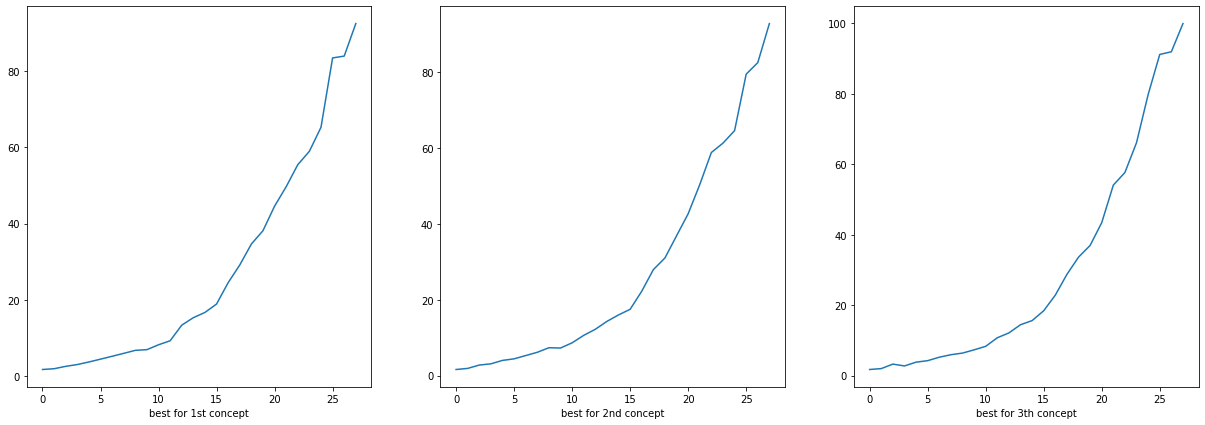

In [ ]:
fig = plt.figure(figsize=(21, 7)) 

ax1 = fig.add_subplot(1, 3, 1) # 서브플롯들을 2 x 1 배열로 배치 그중 첫번째
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.plot(g1_test['predicted_weight_g'])
ax2.plot(g2_test['predicted_weight_g'])
ax3.plot(g3_test['predicted_weight_g'])


ax1.set_xlabel('best for 1st concept')
ax2.set_xlabel('best for 2nd concept')
ax3.set_xlabel('best for 3th concept')

# 감사합니다!